# Emission Measure

In [14]:
import os
import sys
import glob
import copy

import numpy as np
from scipy.interpolate import splev
import matplotlib
import matplotlib.pyplot as plt
from sunpy.map import Map,GenericMap
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
from astropy.coordinates import SkyCoord
import distributed
import dask.array as da

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube
from synthesizAR.analysis.dem import EMCube

sys.path.append('../scripts/')
from dem import HannahKontarModel
sys.path.append('../paper/')
from formatting import hist_step,heating_palette,get_figsize

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [2]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44579 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


First, read in the model and observational data. For now, we'll just take a time-average. It may be better to time-average in chunks though still not completely sure about that...

In [3]:
channels = [94,131,171,193,211,335]
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}/nei/SDO_AIA/{}/map_t{:06d}.fits'

In [4]:
cubes = {}
for f in ['high_frequency','intermediate_frequency','low_frequency']:
    cubes[f] = DistributedAIACollection(*[DistributedAIACube.from_files([
        read_template.format(f,c,i) for i in range(500,2500)]) for c in channels])

Next, set up the temperature bins.

In [5]:
temperature_bin_edges = 10.**np.arange(5.5,7.5,0.1) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

And calculate the instrument responses.

In [6]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [7]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

Now, we'll go through each heating case and compute the emission measure distribution.

### High

In [8]:
maps = [cubes['high_frequency'][c].average() for c in channels]

In [9]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl')

In [10]:
em_high = hk_model.fit(percent_error=0.2)

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
A new version is available: IDL 8.7.1
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.
% Program caused arithmetic error: Floating divide by 0
% Program caused arithmetic error: Floating illegal operand

SSW  setup will include: <gen 

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


In [27]:
tmpcube_meta = copy.deepcopy(em_high[0].meta)
del tmpcube_meta['keycomments']
tmpcube = EMCube(u.Quantity(em_high.as_array(), tmpcube_meta['bunit']), tmpcube_meta, temperature_bin_edges, )
tmpcube.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/dem/emcube_time_averaged.h5')

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


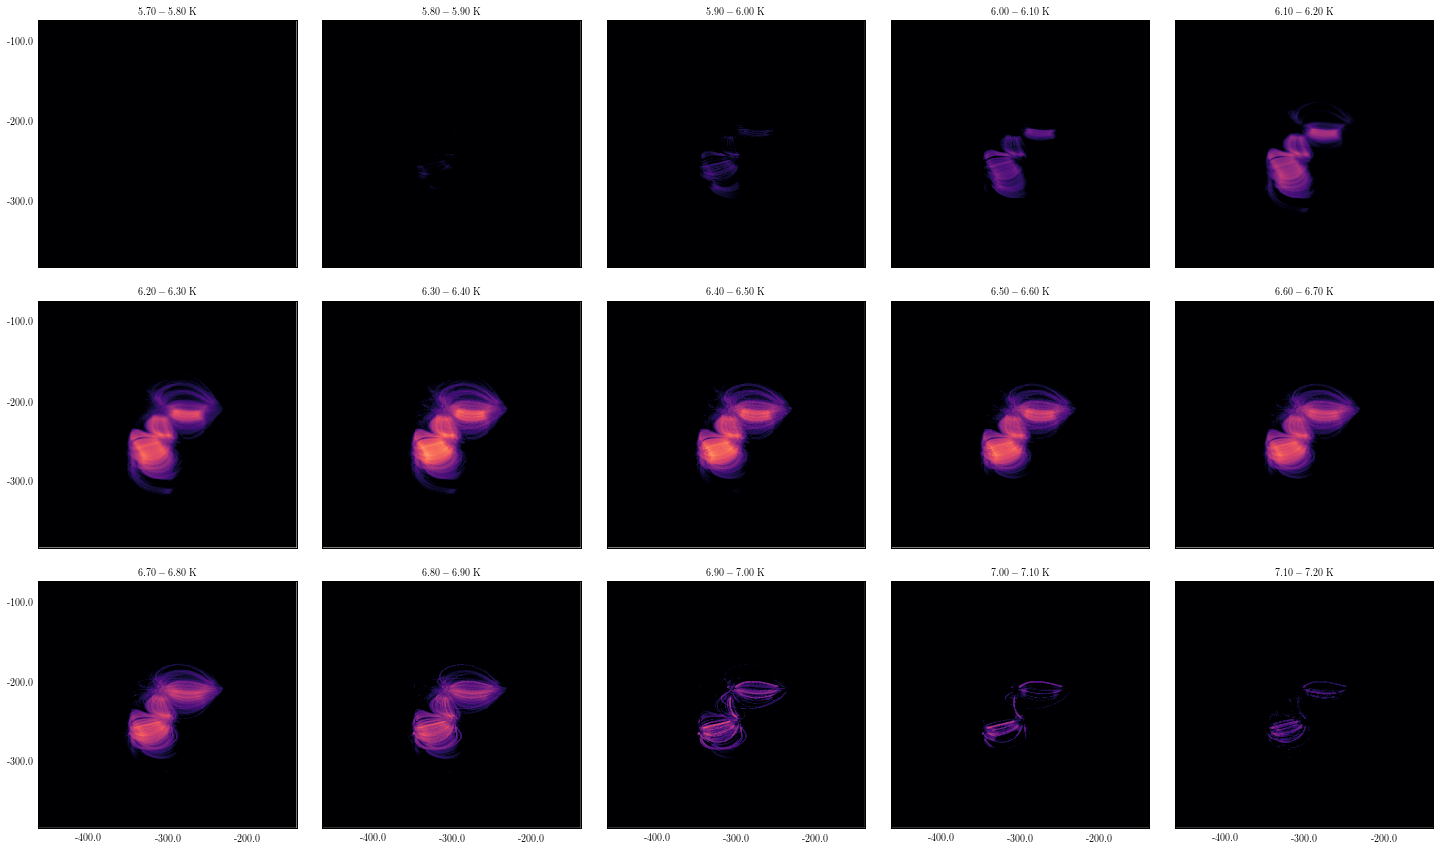

In [25]:
fig = plt.figure(figsize=(25,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i,j in enumerate(np.arange(0,len(em_high),1)[2:-2]):
    m = em_high[j]
    ax = fig.add_subplot(3,5,i+1,projection=m)
    m.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e28),cmap='magma')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%5 != 0:
        lat.set_ticklabel_visible(False)
    if i < 10:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(m.meta["temp_a"]):.2f}-{np.log10(m.meta["temp_b"]):.2f}$ K')

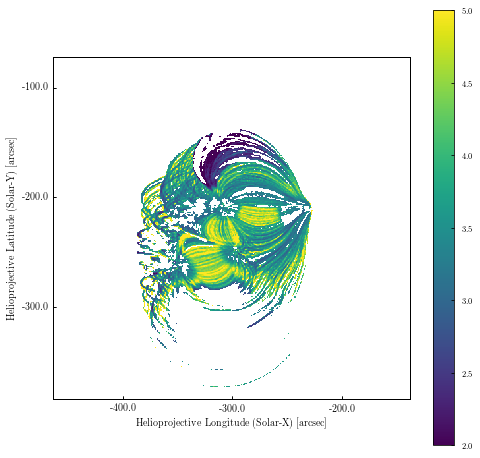

In [26]:
slope_map = em_high.make_slope_map(
    temperature_bounds=[10**(5.8),10**(6.4)]*u.K,
    em_threshold=1e10*u.cm**-5,
    rsquared_tolerance=0.9
)
#slope_map = slope_map.submap(SkyCoord(Tx=-400*u.arcsec,Ty=-300*u.arcsec,frame=slope_map.coordinate_frame),
#                                  SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection=slope_map)
im = slope_map.plot(axes=ax,cmap='viridis',vmin=2,vmax=5,title=False)
fig.colorbar(im,ax=ax)
ax.grid(alpha=0)

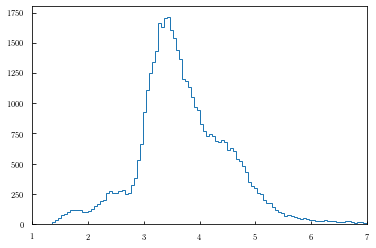

In [531]:
d = slope_map.data.flatten()
plt.hist(d[~np.isnan(d)],bins='fd',histtype='step',);
plt.xlim(1,7);

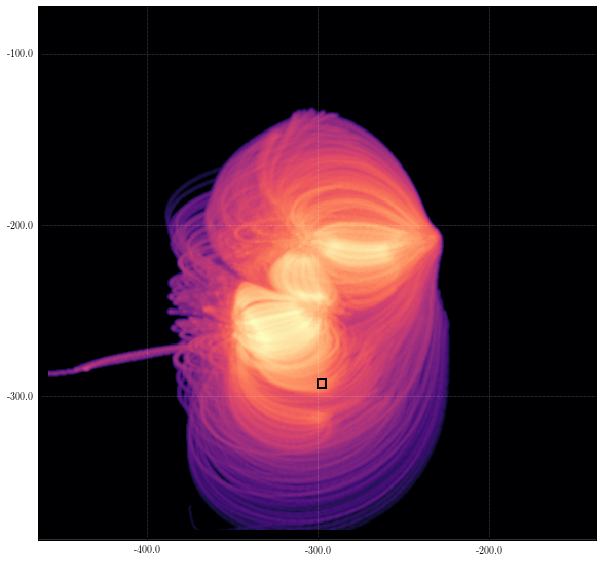

In [157]:
fig = plt.figure(figsize=(10,10))
m = em_high.total_emission
ax = fig.gca(projection=m)
m.plot(annotate=False,title=False,norm=matplotlib.colors.SymLogNorm(1,vmin=1e22,vmax=1e28),cmap='magma')
lc = (-300*u.arcsec,-295*u.arcsec,)
w,h = u.Quantity([5,5],'arcsec')
m.draw_rectangle(SkyCoord(*lc,frame=m.coordinate_frame),w,h,axes=ax,color='k',lw=2);

In [348]:
foo = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/aia.lev1_euv_12s.20110212T153202Z.171.image_lev1.fits')

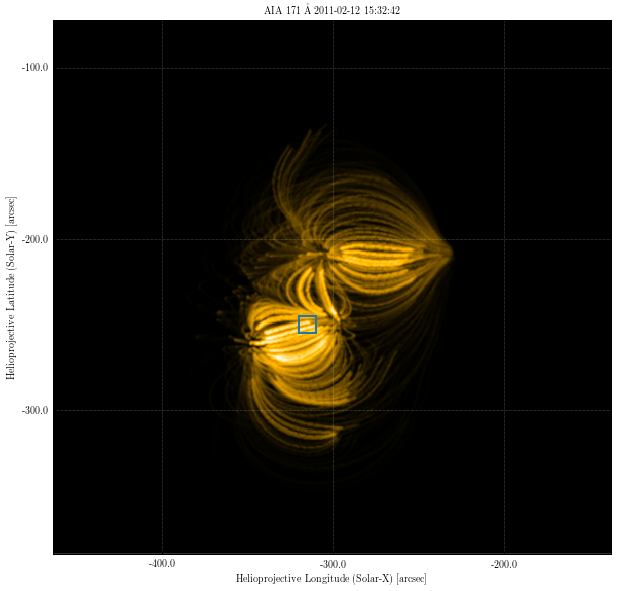

In [500]:
#foo = foo.submap(
#    SkyCoord(-450*u.arcsec, -400*u.arcsec,frame=foo.coordinate_frame),
#    SkyCoord(-100*u.arcsec, -50*u.arcsec, frame=foo.coordinate_frame)
#)
foo = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA/171/map_t001500.fits')
fig = plt.figure(figsize=(10,10));ax = fig.gca(projection=foo)
foo.plot(axes=ax)
cx,cy = (-315*u.arcsec,-250*u.arcsec,)
w,h = u.Quantity([10,10],'arcsec')
foo.draw_rectangle(SkyCoord(Tx=cx-w/2,Ty=cy-h/2,frame=m.coordinate_frame),w,h,axes=ax,color='C0',lw=2);
#cx,cy = (-248.4*u.arcsec,-211.8*u.arcsec,)
#foo.draw_rectangle(SkyCoord(Tx=cx-w/2,Ty=cy-h/2,frame=m.coordinate_frame),w,h,axes=ax,color='C1',lw=2);

In [532]:
em1d = em_high.get_1d_distribution(SkyCoord(Tx=cx-w/2,Ty=cy-h/2,frame=em_high[0].coordinate_frame),
                                   SkyCoord(Tx=cx+w/2,Ty=cy+h/2,frame=em_high[0].coordinate_frame))

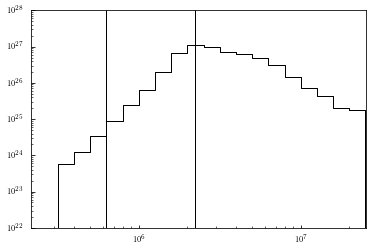

In [533]:
fig = plt.figure();ax=fig.gca()
hist_step(ax,em1d.value,temperature_bin_edges.value,color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((temperature_bin_edges[[0,-1]]+[-1e5,1e5]*u.K).value);
ax.set_ylim(1e22,1e28)
ax.vlines([10**5.8,10.**6.35],*ax.get_ylim())

## Intermediate 

In [28]:
maps = [cubes['intermediate_frequency'][c].average() for c in channels]

In [29]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl')

In [30]:
em_intermediate = hk_model.fit(percent_error=0.2)

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
A new version is available: IDL 8.7.1
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.
% Program caused arithmetic error: Floating divide by 0
% Program caused arithmetic error: Floating illegal operand

SSW  setup will include: <gen 

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


In [31]:
tmpcube_meta = copy.deepcopy(em_intermediate[0].meta)
del tmpcube_meta['keycomments']
tmpcube = EMCube(u.Quantity(em_intermediate.as_array(), tmpcube_meta['bunit']), tmpcube_meta, temperature_bin_edges, )
tmpcube.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/dem/emcube_time_averaged.h5')

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


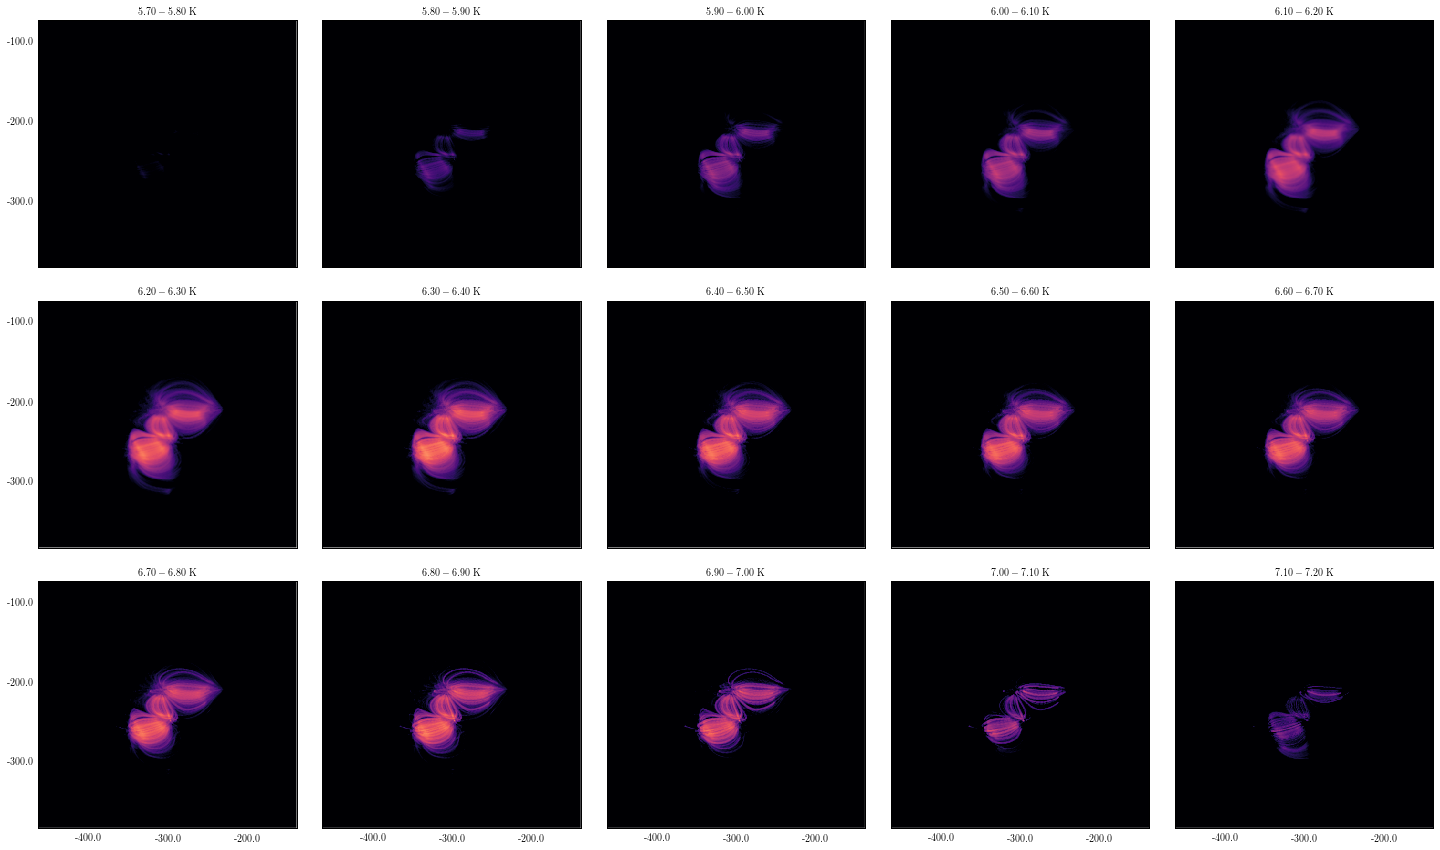

In [165]:
fig = plt.figure(figsize=(25,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i,j in enumerate(np.arange(0,len(em_intermediate),1)[2:-2]):
    m = em_intermediate[j]
    ax = fig.add_subplot(3,5,i+1,projection=m)
    m.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e28))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%5 != 0:
        lat.set_ticklabel_visible(False)
    if i < 10:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(m.meta["temp_a"]):.2f}-{np.log10(m.meta["temp_b"]):.2f}$ K')

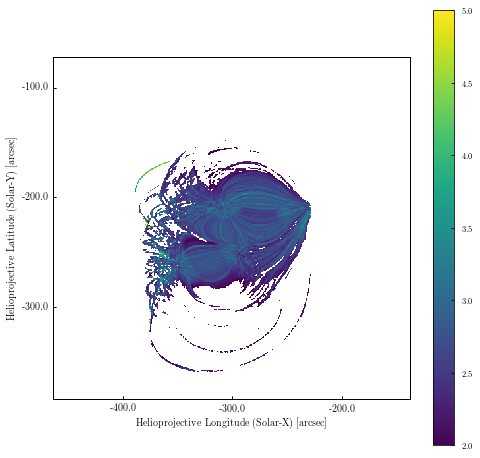

In [540]:
slope_map = em_intermediate.make_slope_map(temperature_bounds=[10**(5.8),10**(6.4)]*u.K,
                                           em_threshold=1e20*u.cm**-5,
                                           rsquared_tolerance=0.9
                                          )
#slope_map = slope_map.submap(SkyCoord(Tx=-400*u.arcsec,Ty=-300*u.arcsec,frame=slope_map.coordinate_frame),
#                                  SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection=slope_map)
im = slope_map.plot(axes=ax,cmap='viridis',vmin=2,vmax=5,title=False)
fig.colorbar(im,ax=ax)
ax.grid(alpha=0)

(1, 7)

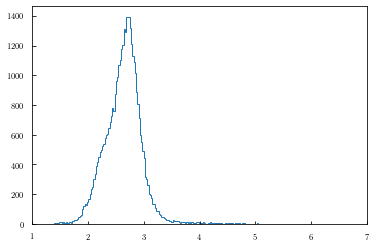

In [541]:
d = slope_map.data.flatten()
plt.hist(d[~np.isnan(d)],bins='fd',histtype='step',);
plt.xlim(1,7)

In [536]:
em1d = em_intermediate.get_1d_distribution(SkyCoord(Tx=cx-w/2,Ty=cy-h/2,frame=em_intermediate[0].coordinate_frame),
                                           SkyCoord(Tx=cx+w/2,Ty=cy+h/2,frame=em_intermediate[0].coordinate_frame))

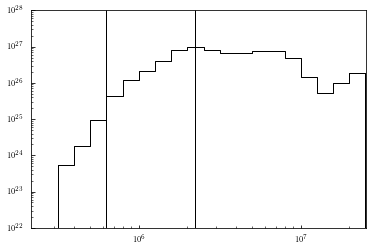

In [537]:
fig = plt.figure();ax=fig.gca()
hist_step(ax,em1d.value,temperature_bin_edges.value,color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((temperature_bin_edges[[0,-1]]+[-1e5,1e5]*u.K).value);
ax.set_ylim(1e22,1e28)
ax.vlines([10**5.8,10.**6.35],*ax.get_ylim())

## Low

In [32]:
maps = [cubes['low_frequency'][c].average() for c in channels]

In [33]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl')

In [34]:
em_low = hk_model.fit(percent_error=0.2)

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
A new version is available: IDL 8.7.1
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.
% Program caused arithmetic error: Floating divide by 0
% Program caused arithmetic error: Floating illegal operand

SSW  setup will include: <gen 

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


In [35]:
tmpcube_meta = copy.deepcopy(em_low[0].meta)
del tmpcube_meta['keycomments']
tmpcube = EMCube(u.Quantity(em_low.as_array(), tmpcube_meta['bunit']), tmpcube_meta, temperature_bin_edges, )
tmpcube.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/dem/emcube_time_averaged.h5')

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


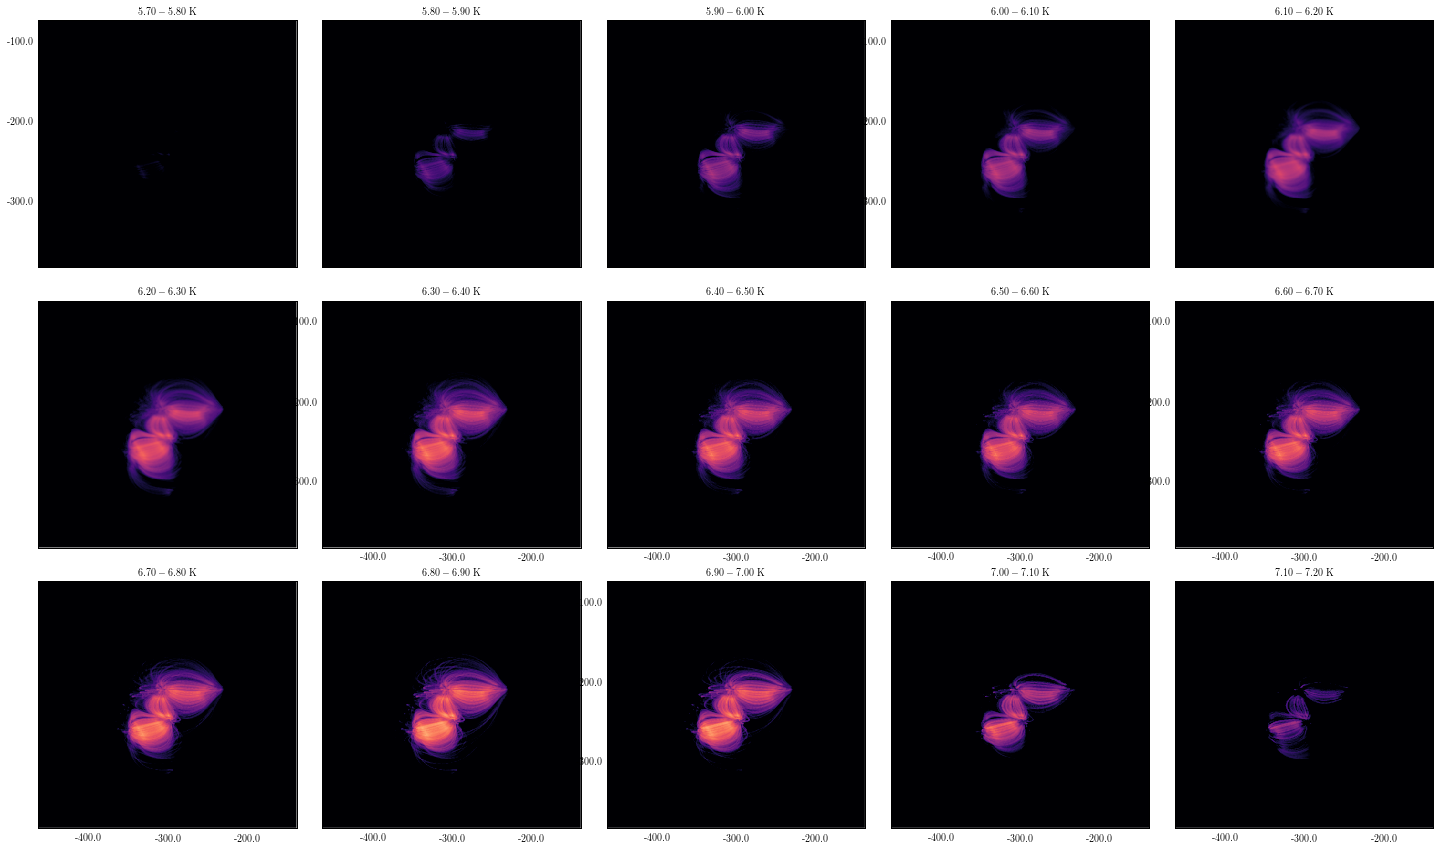

In [137]:
fig = plt.figure(figsize=(25,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i,j in enumerate(np.arange(0,len(em_low),1)[2:-2]):
    m = em_low[j]
    ax = fig.add_subplot(3,5,i+1,projection=m)
    m.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e28))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(m.meta["temp_a"]):.2f}-{np.log10(m.meta["temp_b"]):.2f}$ K')

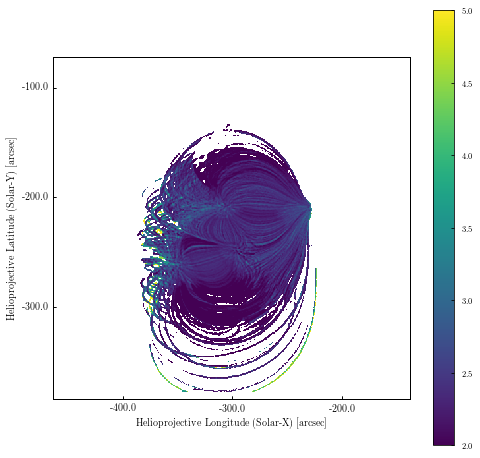

In [542]:
slope_map = em_low.make_slope_map(temperature_bounds=[10**(5.8),10**(6.4)]*u.K,
                                           em_threshold=1e20*u.cm**-5,
                                           rsquared_tolerance=0.9
                                          )
#slope_map = slope_map.submap(SkyCoord(Tx=-400*u.arcsec,Ty=-300*u.arcsec,frame=slope_map.coordinate_frame),
#                                  SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection=slope_map)
im = slope_map.plot(axes=ax,cmap='viridis',vmin=2,vmax=5,title=False)
fig.colorbar(im,ax=ax)
ax.grid(alpha=0)

(1, 7)

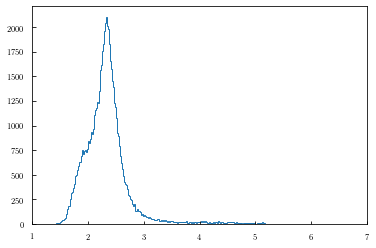

In [543]:
d = slope_map.data.flatten()
plt.hist(d[~np.isnan(d)],bins='fd',histtype='step',);
plt.xlim(1,7)

In [544]:
em1d = em_low.get_1d_distribution(SkyCoord(Tx=cx-w/2,Ty=cy-h/2,frame=em_low[0].coordinate_frame),
                                  SkyCoord(Tx=cx+w/2,Ty=cy+h/2,frame=em_low[0].coordinate_frame))

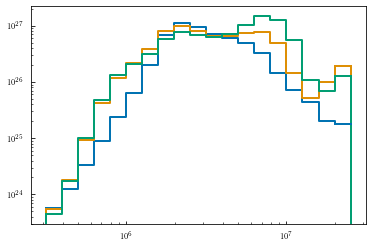

In [546]:
fig = plt.figure();ax=fig.gca()
# High
em1d = em_high.get_1d_distribution(SkyCoord(Tx=cx-w/2,Ty=cy-h/2,frame=em_high[0].coordinate_frame),
                                   SkyCoord(Tx=cx+w/2,Ty=cy+h/2,frame=em_high[0].coordinate_frame))
hist_step(ax,em1d.value,temperature_bin_edges.value,color=heating_palette()[0],lw=2)
# Intermediate
em1d = em_intermediate.get_1d_distribution(SkyCoord(Tx=cx-w/2,Ty=cy-h/2,frame=em_intermediate[0].coordinate_frame),
                                           SkyCoord(Tx=cx+w/2,Ty=cy+h/2,frame=em_intermediate[0].coordinate_frame))
hist_step(ax,em1d.value,temperature_bin_edges.value,color=heating_palette()[1],lw=2)
# Low
em1d = em_low.get_1d_distribution(SkyCoord(Tx=cx-w/2,Ty=cy-h/2,frame=em_low[0].coordinate_frame),
                                  SkyCoord(Tx=cx+w/2,Ty=cy+h/2,frame=em_low[0].coordinate_frame))
hist_step(ax,em1d.value,temperature_bin_edges.value,color=heating_palette()[2],lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(5e5,5e6);
#ax.set_ylim(1e22,7e25)
#ax.vlines([10**5.8,10.**6.4],*ax.get_ylim())

## Comparison 
Make some figures to compare the three cases

Plot the three slope maps

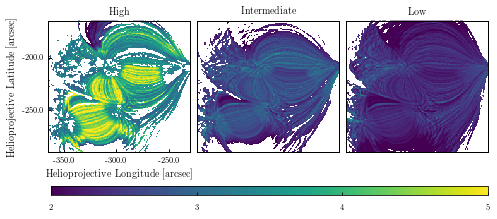

In [549]:
fig = plt.figure(figsize=get_figsize(wf=1.11,hf=0.38))
cax = fig.add_axes([0.13, 0.0, 0.77, 0.04])
labels=['High','Intermediate','Low']
opts = {'cmap': 'viridis', 'vmin': 2, 'vmax': 5, 'title': False, 'annotate': False}
slope_opts = {'temperature_bounds': [10**(5.8),10**(6.4)]*u.K,
              'em_threshold': 1e23*u.cm**-5,
              'rsquared_tolerance': 0.9
             }
for i,em in enumerate([em_high,em_intermediate,em_low]):
    slope_map = em.make_slope_map(**slope_opts)
    slope_map = slope_map.submap(SkyCoord(Tx=-365*u.arcsec,Ty=-290*u.arcsec,frame=slope_map.coordinate_frame),
                                 SkyCoord(Tx=-230*u.arcsec,Ty=-165*u.arcsec,frame=slope_map.coordinate_frame))
    ax = fig.add_subplot(1,len(labels),i+1,projection=slope_map)
    im = slope_map.plot(axes=ax,**opts)
    ax.grid(alpha=0)
    lon,lat = ax.coords
    if i > 0:
        lon.set_ticks_visible(False)
        lon.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
        lat.set_ticklabel_visible(False)
    else:
        lat.set_ticks(number=3)
        lon.set_axislabel('Helioprojective Longitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
        lat.set_axislabel('Helioprojective Latitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
        lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
        lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
    ax.set_title(labels[i])
plt.subplots_adjust(hspace=0.,wspace=0.05)
cbar = fig.colorbar(im,cax=cax,orientation='horizontal');
cbar.set_ticks([2,3,4,5])
#fig.savefig('figures/em_slope_maps.pdf')

Now, overplot the three slope distributions

High
--------
peak = 3.325000000000002
Intermediate
--------
peak = 2.7250000000000014
Low
--------
peak = 2.325000000000001


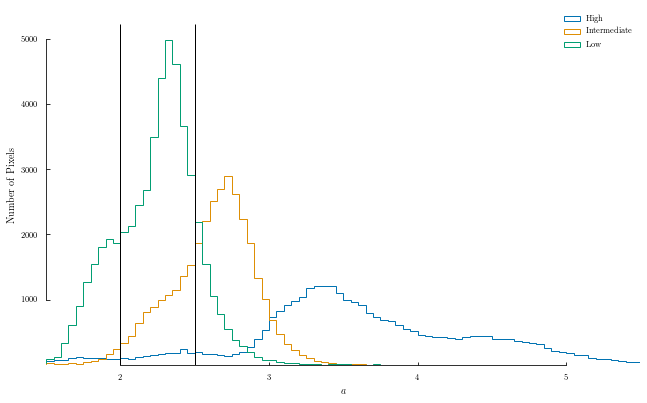

In [570]:
fig = plt.figure(figsize=get_figsize(wf=1.5))
ax = fig.gca()
bins = np.arange(1,6,0.05)
bin_centers = (bins[:-1] + bins[1:])/2
opts = {'bins': bins, 'histtype': 'step','density':False, 'lw':1}
for i,em in enumerate([em_high,em_intermediate,em_low]):
    slope_map = em.make_slope_map(**slope_opts)
    d = slope_map.data.flatten()
    h,b,_ = ax.hist(d[~np.isnan(d)],**opts,color=heating_palette()[i],label=labels[i])
ax.set_xlim(1.5,5.5);
ax.set_xticks([2,3,4,5])
ax.legend(frameon=False,loc=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_ylim([50,5001])
ax.set_yticks(ax.get_yticks()[1:-1])
ax.spines['left'].set_bounds(ax.get_yticks()[0],ax.get_yticks()[-1])
ax.spines['bottom'].set_bounds(ax.get_xticks()[0],ax.get_xticks()[-1])
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'Number of Pixels')
#fig.savefig('figures/em_slope_histograms.pdf')

## Comparisons with Timelags

In [561]:
channel_pairs = [(94,335),(94,171),(94,193),(94,131),(94,211),
                 (335,131),(335,193),(335,211),(335,171),
                 (211,131),(211,171),(211,193),(193,171),(193,131),(171,131),]
cmap = plt.cm.inferno
cmap.set_bad(color='w')
norm=matplotlib.colors.LogNorm(vmin=1,vmax=5e2)
bins = np.linspace(0,1,50)

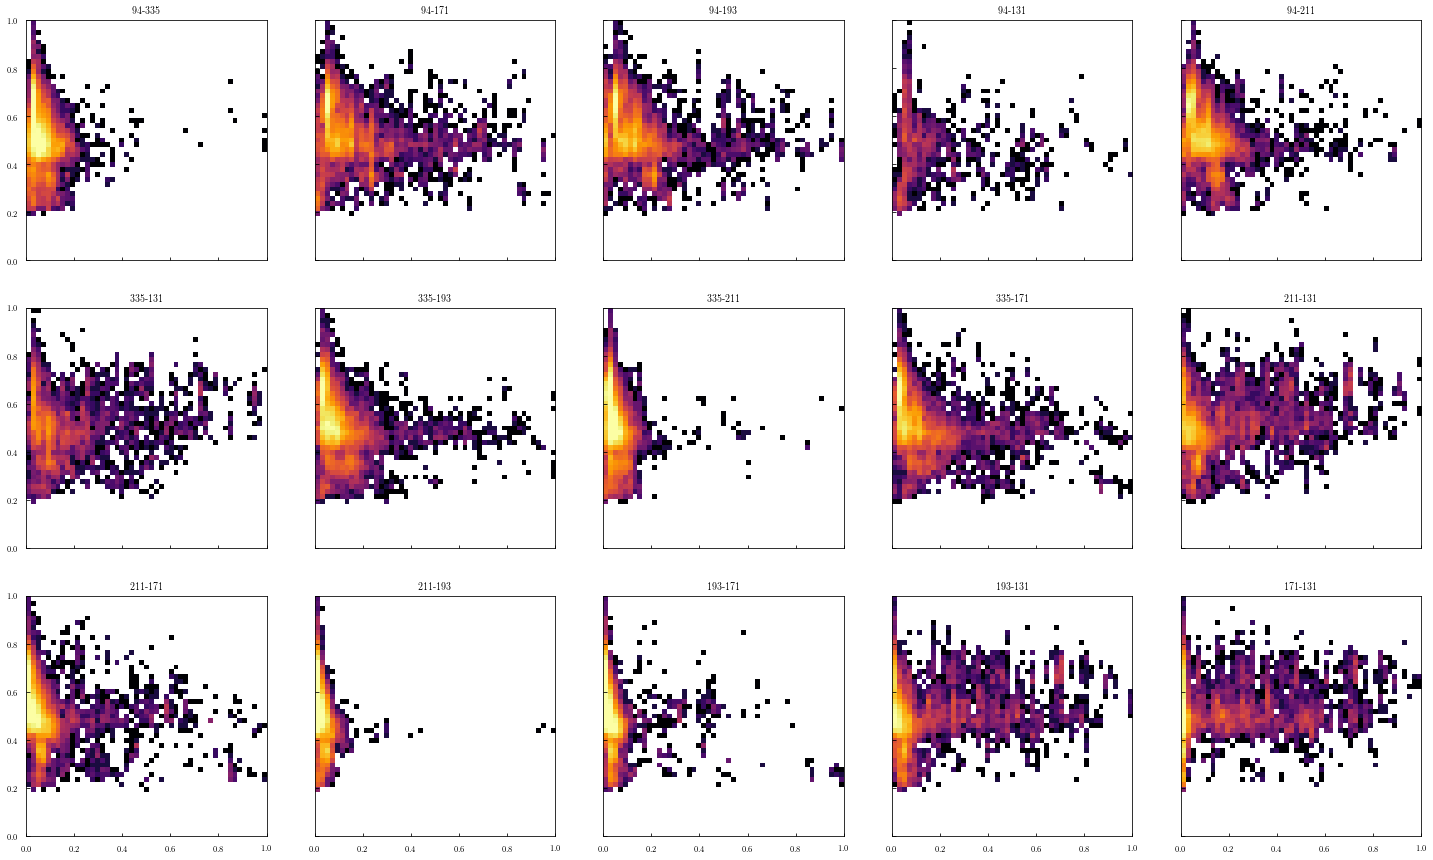

In [562]:
fig,axes = plt.subplots(3,5,figsize=(25,15),sharex=True,sharey=True)
# Get the slopes
m_slope = em_high.make_slope_map(**slope_opts)
i_nonan = np.where(~np.isnan(m_slope.data))
slope_points = m_slope.data[i_nonan].flatten()
# Plot against timelags
for ax,(ca,cb) in zip(axes.flatten(),channel_pairs):
    timelag_points = Map(f'/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/timelags/timelag_{ca}_{cb}.fits').data[i_nonan].flatten()
    _slope_points = slope_points[timelag_points>0]
    timelag_points = timelag_points[timelag_points>0]
    _,_,_,im = ax.hist2d(
        timelag_points/timelag_points.max(),
        _slope_points/_slope_points.max(),
        bins=bins,
        cmap=cmap,
        norm=norm,
    );
    ax.set_title(f'{ca}-{cb}')

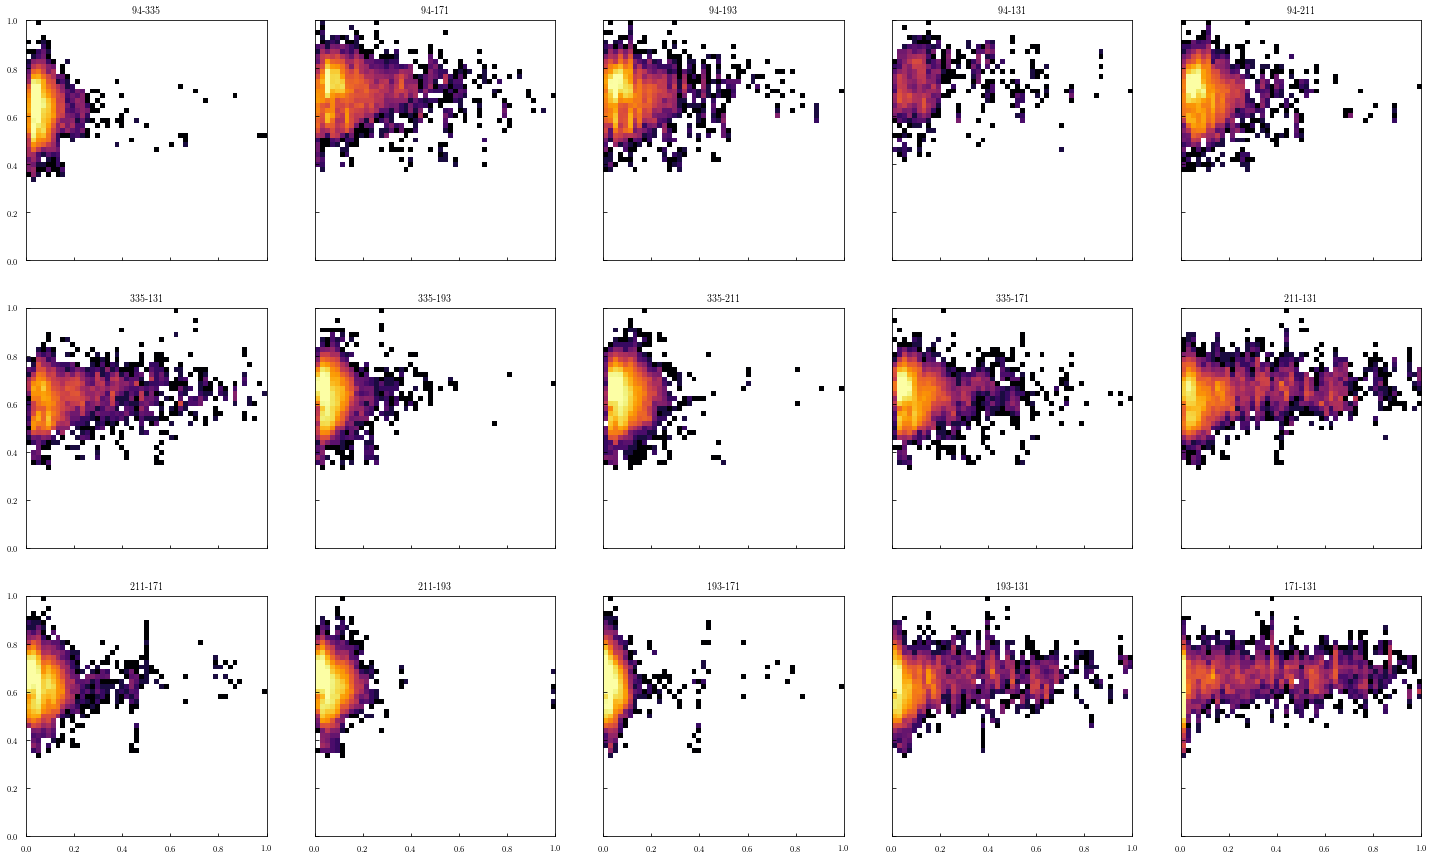

In [563]:
fig,axes = plt.subplots(3,5,figsize=(25,15),sharex=True,sharey=True)
# Get the slopes
m_slope = em_intermediate.make_slope_map(**slope_opts)
i_nonan = np.where(~np.isnan(m_slope.data))
slope_points = m_slope.data[i_nonan].flatten()
# Plot against timelags
for ax,(ca,cb) in zip(axes.flatten(),channel_pairs):
    timelag_points = Map(f'/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/timelags/timelag_{ca}_{cb}.fits').data[i_nonan].flatten()
    _slope_points = slope_points[timelag_points>0]
    timelag_points = timelag_points[timelag_points>0]
    _,_,_,im = ax.hist2d(
        timelag_points/timelag_points.max(),
        _slope_points/_slope_points.max(),
        bins=bins,
        cmap=cmap,
        norm=norm,
    );
    ax.set_title(f'{ca}-{cb}')

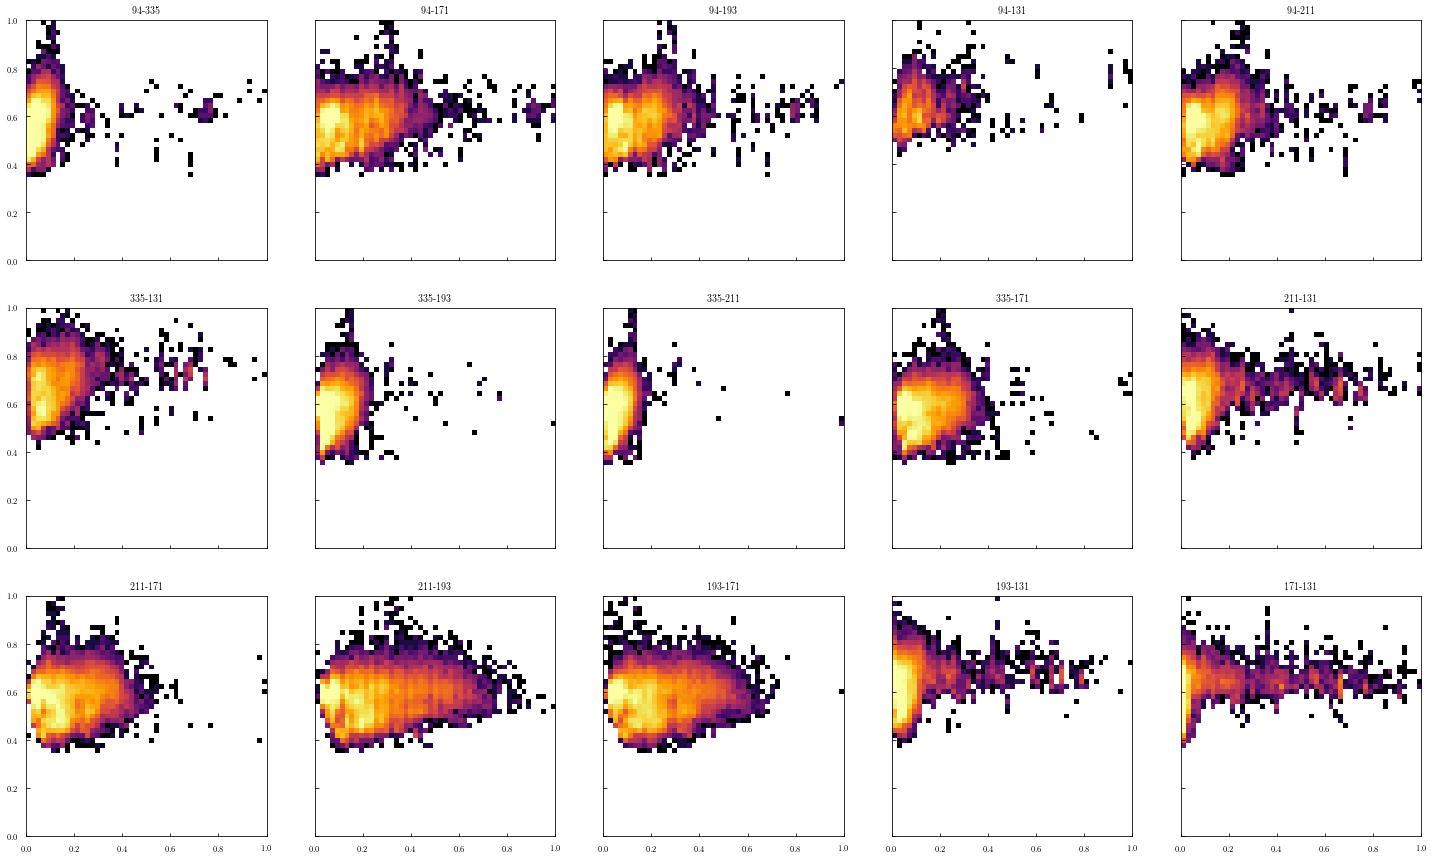

In [564]:
fig,axes = plt.subplots(3,5,figsize=(25,15),sharex=True,sharey=True)
# Get the slopes
m_slope = em_low.make_slope_map(**slope_opts)
i_nonan = np.where(~np.isnan(m_slope.data))
slope_points = m_slope.data[i_nonan].flatten()
# Plot against timelags
for ax,(ca,cb) in zip(axes.flatten(),channel_pairs):
    timelag_points = Map(f'/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/timelags/timelag_{ca}_{cb}.fits').data[i_nonan].flatten()
    _slope_points = slope_points[timelag_points>0]
    timelag_points = timelag_points[timelag_points>0]
    _,_,_,im = ax.hist2d(
        timelag_points/timelag_points.max(),
        _slope_points/_slope_points.max(),
        bins=bins,
        cmap=cmap,
        norm=norm,
    );
    ax.set_title(f'{ca}-{cb}')

In [420]:
np.log10(2e6)

6.301029995663981

In [426]:
10**(5.75)/1e6

0.5623413251903492

In [427]:
10**6.35

2238721.138568338

In [428]:
np.log10(3e6)

6.477121254719663

In [433]:
t = np.logspace(5,8,1000)
t[np.argmax(splev(t,aia.channels[-2]['temperature_response_spline']))]/1e6

1.850407019542302